<a href="https://colab.research.google.com/github/Evraa/Graduation-Project-Separate-Modules/blob/main/models/Emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import pandas as pd
import cv2
import numpy as np

In [ ]:
import tensorflow as tf
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12187025761235313039
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14509932544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11194983230466140241
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
dataset_path = "drive/MyDrive/fer2013.csv"
image_size=(48,48)

def load_data():
        data = pd.read_csv(dataset_path)
        pixels = data['pixels'].tolist()
        width, height = 48, 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'),image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions

In [ ]:
def preprocess_input(x):
    x = x.astype('float32')
    x = x / 255.0
    return x

In [ ]:
# parameters
batch_size = 32
num_epochs = 10000
input_shape = (48, 48, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50
base_path = '/'

In [ ]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [ ]:
def create_model(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
                                            use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
            #kernel_regularizer=regularization,
            padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax',name='predictions')(x)

    model = Model(img_input, output)
    return model

In [ ]:
model = create_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48, 48, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 46, 46, 8)    72          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 46, 46, 8)    32          conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation_12 (Activation)      (None, 46, 46, 8)    0           batch_normalization_28[0][0]     
____________________________________________________________________________________________

In [ ]:
  # callbacks
log_file_path = base_path +'_emotion_training.log'
csv_logger = CSVLogger(log_file_path, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                                  patience=int(patience/4), verbose=1)
trained_models_path = base_path +'_CNN_Trained'
model_names = trained_models_path + '.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,
                                                    save_best_only=True)
callbacks = [model_checkpoint, csv_logger, early_stop, reduce_lr]

In [ ]:
faces, emotions = load_data()
faces = preprocess_input(faces)
num_samples, num_classes = emotions.shape
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)


In [ ]:
model.fit(data_generator.flow(xtrain, ytrain,
                                            batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))

Epoch 1/10000
897/897 [==============================] - 25s 25ms/step - loss: 1.8878 - accuracy: 0.2814 - val_loss: 1.6760 - val_accuracy: 0.3817

Epoch 00001: val_loss improved from inf to 1.67601, saving model to /_CNN_Trained.01-0.38.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10000
897/897 [==============================] - 20s 22ms/step - loss: 1.5607 - accuracy: 0.4183 - val_loss: 1.5248 - val_accuracy: 0.4324

Epoch 00002: val_loss improved from 1.67601 to 1.52476, saving model to /_CNN_Trained.02-0.43.hdf5
Epoch 3/10000
897/897 [==============================] - 20s 22ms/step - loss: 1.4373 - accuracy: 0.4674 - val_loss: 1.3971 - val_accuracy: 0.4699

Epoch 00003: val_loss improved from 1.52476 to 1.39711, saving model to /_CNN_Trained.03-0.47.hdf5
Epoch 4/10000
897/897 [==============================] - 21s 23ms/step - loss: 1.3632 - accuracy: 0.4903 - val_loss: 1.3680 - val_accuracy: 0.5040

Epoch 00004: val_loss improved from 1.39711 to 1.36796, saving model to /_CNN_Trained.04-0.50.hdf5
Epoch 5/10000
897/897 [==============================] - 20s 22ms/step - loss: 1.3057 - accuracy: 0.5140 - val_loss: 1.3513 - val_accuracy: 0.5106

Epoch 00005: val_loss improved from 1.36796 to 1.35127, saving model to /_CNN_Trained.05-0.51.hdf5
Epoch 6/1000

In [ ]:
# show training/validation history
log_path = 'drive/MyDrive/_emotion_training.log'
history = pd.read_csv(log_path)

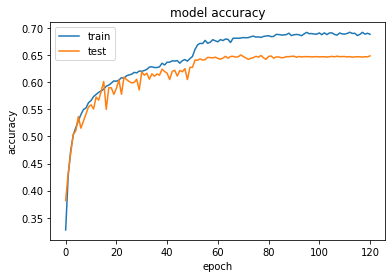

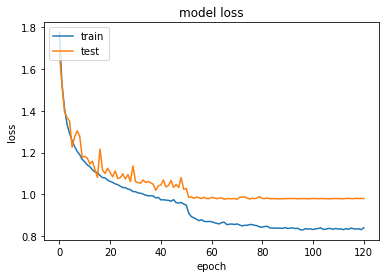

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/Emotion_detection_CNN_acc.jpg"
plt.savefig(dpi=200, fname=path)
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
path = "drive/MyDrive/Emotion_detection_CNN_loss.jpg"
plt.savefig(dpi=200, fname=path)
plt.show()

Prediction 


In [ ]:
detection_model_path = 'drive/MyDrive/haarcascade_frontalface_default.xml'
emotion_model_path = 'drive/MyDrive/_CNN_Trained.102-0.66.hdf5'
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised",
 "neutral"]

In [ ]:
from google.colab.patches import cv2_imshow
# send path of image [change for frame incase of video]
def predict(path):
  image = cv2.imread(path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = face_detection.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
  if len(faces) > 0:
    # we detect 1 face only for now #index of 0
    face = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = face
    roi = gray[fY:fY + fH, fX:fX + fW]
    # cv2_imshow(roi)
    roi = cv2.resize(roi, (64, 64))
    cv2_imshow(roi)
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    scores = emotion_classifier.predict(roi)
    max_emotion_probability = np.max(scores)
    label = EMOTIONS[scores.argmax()]
    return label, scores,max_emotion_probability

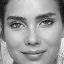

happy [[3.7980956e-04 5.4927114e-06 4.0598535e-03 8.8656670e-01 8.5241132e-04
  6.2404497e-04 1.0751165e-01]] 0.8865667


In [ ]:
# image = cv2.imread("/img.png")
image_path = "/img1.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)

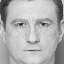

neutral [[5.6911372e-02 6.7730769e-05 1.3008487e-01 1.9900111e-02 6.7562379e-02
  8.1523908e-03 7.1732116e-01]] 0.71732116


In [ ]:
image_path = "/img2.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)

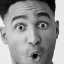

surprised [[3.4827335e-05 5.9346405e-08 8.0771174e-04 2.5797067e-06 1.8890778e-05
  9.9912792e-01 7.9740676e-06]] 0.9991279


In [ ]:
image_path = "/img3.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)

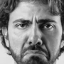

angry [[7.2753572e-01 5.2474916e-04 5.5359561e-02 1.9778685e-05 1.5787219e-01
  6.3577695e-03 5.2330203e-02]] 0.7275357


In [ ]:
image_path = "/img4.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)

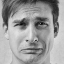

sad [[1.3185941e-01 6.3354964e-05 1.0466852e-01 1.0979351e-03 5.8813566e-01
  3.1423628e-02 1.4275150e-01]] 0.58813566


In [ ]:
image_path = "/img5.png"
label,scores,emotion_probability = predict(image_path)
print(label,scores,emotion_probability)

In [ ]:
from google.colab.patches import cv2_imshow
# send path of image [change for frame incase of video]
def predict(path):
  image = cv2.imread(path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = face_detection.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
  if len(faces) > 0:
    # we detect 1 face only for now #index of 0
    face = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = face
    roi = gray[fY:fY + fH, fX:fX + fW]
    # cv2_imshow(roi)
    roi = cv2.resize(roi, (64, 64))
    cv2_imshow(roi)
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    scores = emotion_classifier.predict(roi)
    max_emotion_probability = np.max(scores)
    label = EMOTIONS[scores.argmax()]
    return label, scores,max_emotion_probability